In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-4/Data-dictionary.xlsx
/kaggle/input/data-storm-4/DataStorm4.0_KaggleProblemStatement.pdf
/kaggle/input/data-storm-4/Store-info.csv
/kaggle/input/data-storm-4/Testing-data.csv
/kaggle/input/data-storm-4/Historical-transaction-data.csv


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold

store_info_data = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')
historical_data = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv')
testing_data = pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv')

print(store_info_data.head())
print(historical_data.head())
print(testing_data.head())

   shop_id  shop_area_sq_ft shop_profile
0  SHOP047              528     Moderate
1  SHOP009              676         High
2  SHOP083              676          Low
3  SHOP117              676          Low
4  SHOP042              676          Low
        item_description          transaction_date  invoice_id customer_id  \
0     ORANGE BARLEY 1.5L  2021-12-11T00:00:00.000Z       147.0        BGXA   
1       GINGER BEER 1.5L  2021-10-17T00:00:00.000Z       371.0        IA25   
2        TONIC PET 500ML  2021-12-13T00:00:00.000Z       484.0        VN7V   
3          CREAM SODA 1L  2021-12-13T00:00:00.000Z       484.0        VN7V   
4  STRAWBERRY MILK 180ML  2021-10-23T00:00:00.000Z      1310.0        7S00   

   shop_id  item_price  quantity_sold  
0  SHOP008         220              2  
1  SHOP112         220              2  
2  SHOP008         160              2  
3  SHOP008         150              2  
4  SHOP112         210              5  
   shop_id  shop_profile
0  SHOP046          

In [20]:
historical_data.isna().sum()

item_description    35928
transaction_date        0
invoice_id           6320
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
dtype: int64

In [21]:
hd = historical_data.copy()
len(hd) - len(hd.drop_duplicates())

31211

In [22]:
hd. nunique()

item_description        37
transaction_date        62
invoice_id          343342
customer_id         191636
shop_id                124
item_price             209
quantity_sold           69
dtype: int64

In [23]:
hd[(hd['quantity_sold']==0)]

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
54,CREAM SODA 500ML,2021-12-09T00:00:00.000Z,24423.0,E5FE,SHOP003,100,0
103,SODA 500ML,2021-10-31T00:00:00.000Z,31745.0,ZJY2,SHOP090,70,0
230,CREAM SODA 1.5L,2021-12-10T00:00:00.000Z,52904.0,57RR,SHOP040,220,0
273,NECTO 1.5L,2021-11-12T00:00:00.000Z,59336.0,UVU7,SHOP103,220,0
465,LEMONADE 500ML,2021-11-10T00:00:00.000Z,111021.0,K58C,SHOP032,100,0
...,...,...,...,...,...,...,...
473838,CREAM SODA 1.5L,2021-11-29T00:00:00.000Z,NaN,ZEVD,SHOP021,220,0
473863,FIT O MANGO 1L,2021-10-16T00:00:00.000Z,NaN,M0LJ,SHOP101,290,0
473884,CREAM SODA 1.5L,2021-10-27T00:00:00.000Z,NaN,UARW,SHOP072,220,0
473913,CREAM SODA 500ML,2021-12-09T00:00:00.000Z,NaN,N0BG,SHOP027,100,0


**DUPLICATES**

    Need to try with duplicates in the invoice intact and with the duplicates dropped.

**ZERO QUANTITY**

	Need to be dropped.

In [24]:
# Keeping duplicates and proceeding
# Assuming that duplicates are multiple items in the same bill
indexQuantity = historical_data[(historical_data['quantity_sold'] == 0)].index
historical_data.drop(indexQuantity,inplace = True)

In [25]:
#historical_data.drop(indexQuantity,inplace = True)

In [26]:
len(historical_data) - len(hd)

-8339

In [27]:
shops = hd.groupby(['shop_id'])
num_invs_per_shop = {}

for i in shops:
    num_invs_per_shop[i[0]] = i[1]['invoice_id'].nunique()
    
    
    print(i[0], end = ' - ')
    print(i[1]['invoice_id'].nunique())
    
    

SHOP001 - 1537
SHOP002 - 3769
SHOP003 - 2867
SHOP004 - 2641
SHOP005 - 3183
SHOP006 - 2886
SHOP007 - 2903
SHOP008 - 203
SHOP009 - 3493
SHOP010 - 3437
SHOP011 - 4854
SHOP012 - 1869
SHOP013 - 2798
SHOP014 - 3351
SHOP015 - 2400
SHOP016 - 4477
SHOP017 - 3045
SHOP018 - 3972
SHOP019 - 3045
SHOP020 - 3537
SHOP021 - 2631
SHOP022 - 2408
SHOP023 - 3138
SHOP024 - 2302
SHOP025 - 2628
SHOP026 - 3316
SHOP027 - 2718
SHOP028 - 2827
SHOP029 - 2875
SHOP030 - 2779
SHOP031 - 2821
SHOP032 - 2167
SHOP033 - 3955
SHOP034 - 1844
SHOP035 - 1780
SHOP036 - 2997
SHOP037 - 2990
SHOP038 - 2597
SHOP039 - 3413
SHOP040 - 2418
SHOP041 - 2482
SHOP042 - 2495
SHOP043 - 4986
SHOP044 - 2082
SHOP045 - 3459
SHOP046 - 2735
SHOP047 - 1302
SHOP048 - 2178
SHOP049 - 3040
SHOP050 - 3159
SHOP051 - 3230
SHOP052 - 3423
SHOP053 - 3237
SHOP054 - 2232
SHOP055 - 1915
SHOP056 - 4320
SHOP057 - 1986
SHOP058 - 4128
SHOP059 - 3601
SHOP060 - 2895
SHOP061 - 2345
SHOP062 - 4075
SHOP063 - 2999
SHOP065 - 2550
SHOP066 - 2533
SHOP067 - 2554
SHOP068 - 3

In [28]:
store_info_data[(store_info_data['shop_id']=='SHOP008')]

,shop_id,shop_area_sq_ft,shop_profile
51,SHOP008,678,Moderate


In [29]:
historical_data.describe()

,invoice_id,item_price,quantity_sold
count,4.594190e+05,465635.000000,465635.000000
mean,1.996392e+06,207.492564,1.959990
std,1.344602e+06,167.876200,1.628485
min,1.700000e+01,35.000000,-1.000000
25%,1.031958e+06,100.000000,1.000000
50%,2.032760e+06,200.000000,2.000000
75%,3.032256e+06,220.000000,2.000000
max,8.331754e+06,17400.000000,101.000000


In [30]:
historical_data['total_price'] = historical_data['quantity_sold'] * historical_data['item_price']

shop_wise_features = historical_data.groupby('shop_id').agg(
     invoice_count = ('invoice_id',pd.Series.nunique),
     customer_count = ('customer_id',pd.Series.nunique),
     item_count = ('quantity_sold', 'sum'),
     total_sales = ('total_price', 'sum')
     ).reset_index()
# shop_wise_features.head()

dataset = pd.merge(store_info_data, shop_wise_features, on='shop_id', how='outer')
dataset.head()

,shop_id,shop_area_sq_ft,shop_profile,invoice_count,customer_count,item_count,total_sales
0,SHOP047,528,Moderate,1285,920,3288,842960
1,SHOP009,676,High,3457,2476,8411,1970870
2,SHOP083,676,Low,2675,1876,6644,1691985
3,SHOP117,676,Low,3121,2015,8073,2325980
4,SHOP042,676,Low,2466,1826,5844,1340215


In [31]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales
count,124.000000,124.000000,124.000000,124.000000,1.240000e+02
mean,619.991935,2870.564516,1992.758065,7360.000000,2.152114e+06
std,126.770165,818.898817,562.809783,2168.576664,7.953239e+05
min,298.000000,200.000000,187.000000,502.000000,1.312450e+05
25%,553.250000,2368.250000,1607.250000,5857.250000,1.639405e+06
50%,617.000000,2856.500000,2010.500000,7230.500000,2.062812e+06
75%,676.000000,3389.000000,2397.500000,8694.750000,2.617150e+06
max,1077.000000,4912.000000,3462.000000,13394.000000,6.051205e+06


In [32]:
dataset[(dataset['shop_id']=='SHOP008')]

,shop_id,shop_area_sq_ft,shop_profile,invoice_count,customer_count,item_count,total_sales
51,SHOP008,678,Moderate,200,187,502,131245


In [33]:
dataset['InvoiceCount_Category'] = pd.cut(dataset['invoice_count'], bins=list(range(0,5001,500)))

<AxesSubplot:xlabel='InvoiceCount_Category', ylabel='count'>

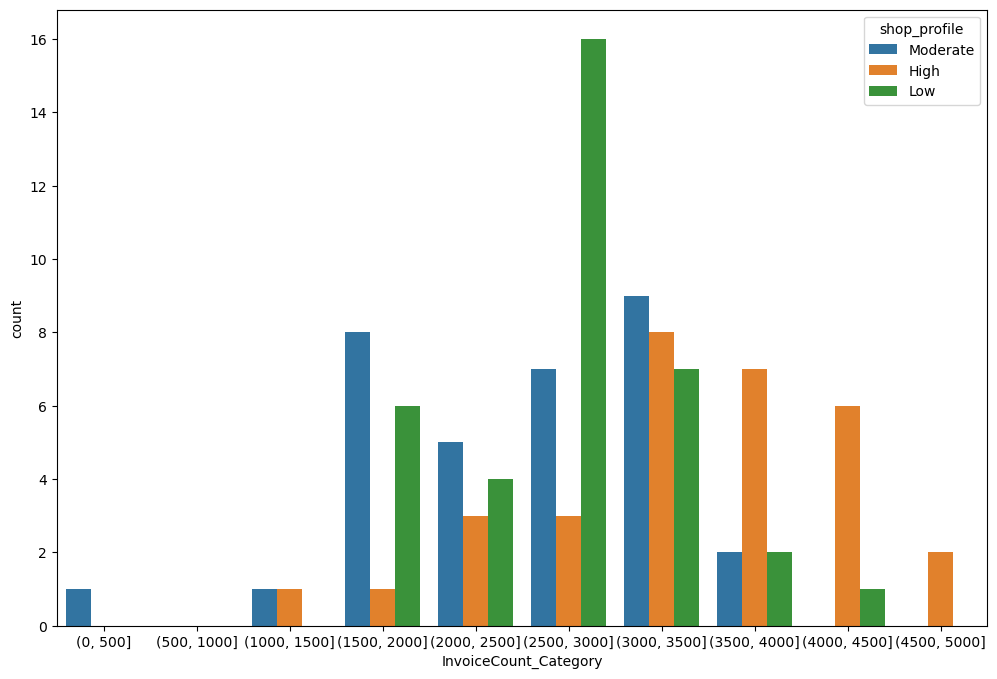

In [34]:
plt.figure(figsize=(12, 8))
sns.countplot(x = 'InvoiceCount_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='CustomerCount_Category', ylabel='count'>

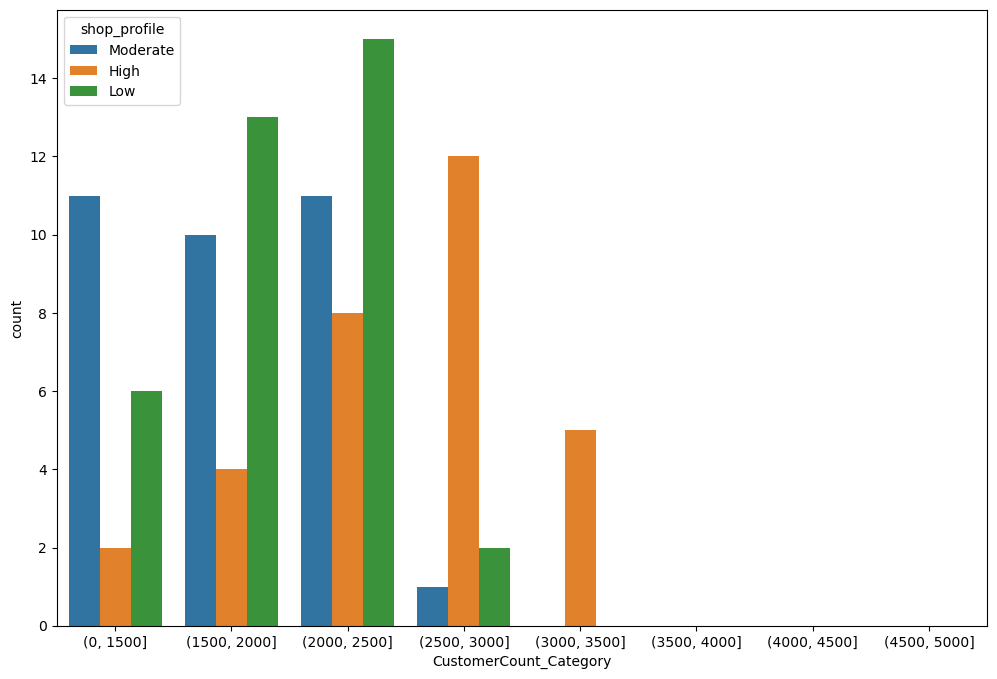

In [69]:
dataset['CustomerCount_Category'] = pd.cut(dataset['customer_count'], bins=[0]+list(range(1500,5001,500)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'CustomerCount_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='Area_Category', ylabel='count'>

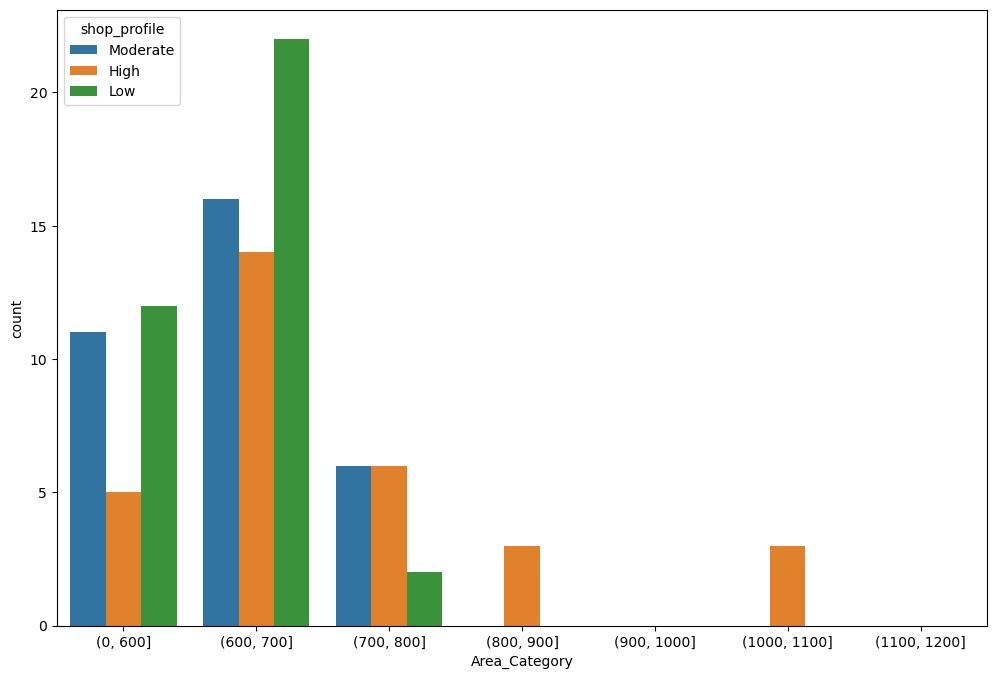

In [63]:
dataset['Area_Category'] = pd.cut(dataset['shop_area_sq_ft'], bins=[0]+list(range(600,1201,100)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'Area_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='ItemCount_Category', ylabel='count'>

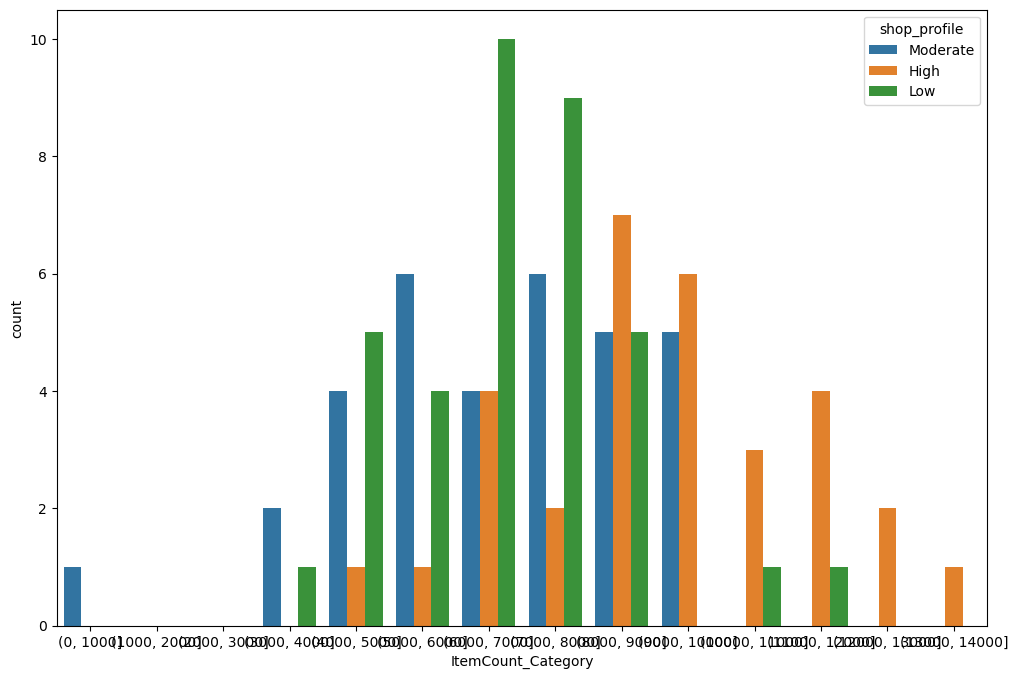

In [37]:
dataset['ItemCount_Category'] = pd.cut(dataset['item_count'], bins=list(range(0,14001,1000)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'ItemCount_Category', data= dataset, hue='shop_profile')

In [38]:
6.051205e+06

6051205.0

In [39]:
dataset['total_sales'] = dataset['total_sales']/10000

In [40]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales
count,124.000000,124.000000,124.000000,124.000000,124.000000
mean,619.991935,2870.564516,1992.758065,7360.000000,215.211448
std,126.770165,818.898817,562.809783,2168.576664,79.532387
min,298.000000,200.000000,187.000000,502.000000,13.124500
25%,553.250000,2368.250000,1607.250000,5857.250000,163.940500
50%,617.000000,2856.500000,2010.500000,7230.500000,206.281250
75%,676.000000,3389.000000,2397.500000,8694.750000,261.715000
max,1077.000000,4912.000000,3462.000000,13394.000000,605.120500


<AxesSubplot:xlabel='Sales_Category', ylabel='count'>

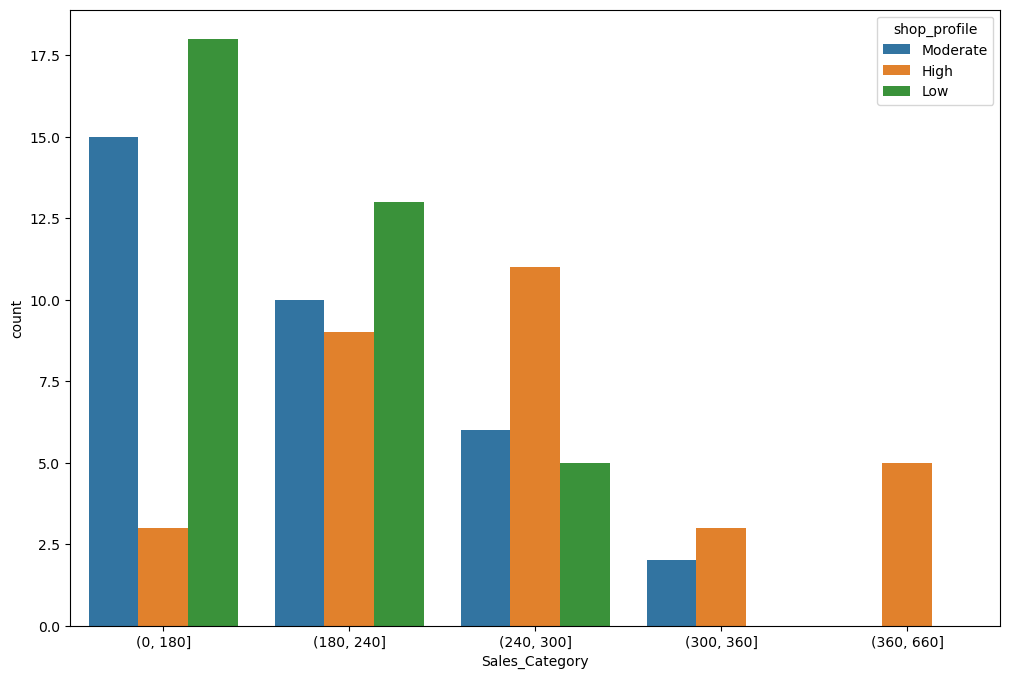

In [60]:
dataset['Sales_Category'] = pd.cut(dataset['total_sales'], bins=[0]+list(range(180,361,60))+[660])

plt.figure(figsize=(12, 8))
sns.countplot(x = 'Sales_Category', data= dataset, hue='shop_profile')

In [42]:
historical_data.describe()

,invoice_id,item_price,quantity_sold,total_price
count,4.594190e+05,465635.000000,465635.000000,4.656350e+05
mean,1.996392e+06,207.492564,1.959990,5.731146e+02
std,1.344602e+06,167.876200,1.628485,3.492484e+03
min,1.700000e+01,35.000000,-1.000000,-2.900000e+02
25%,1.031958e+06,100.000000,1.000000,1.500000e+02
50%,2.032760e+06,200.000000,2.000000,2.400000e+02
75%,3.032256e+06,220.000000,2.000000,4.400000e+02
max,8.331754e+06,17400.000000,101.000000,1.061400e+06


In [43]:
dataset

,shop_id,shop_area_sq_ft,shop_profile,invoice_count,customer_count,item_count,total_sales,InvoiceCount_Category,CustomerCount_Category,Area_Category,ItemCount_Category,Sales_Category
0,SHOP047,528,Moderate,1285,920,3288,84.2960,"(1000, 1500]","(500, 1000]","(500, 600]","(3000, 4000]","(60, 120]"
1,SHOP009,676,High,3457,2476,8411,197.0870,"(3000, 3500]","(2000, 2500]","(600, 700]","(8000, 9000]","(180, 240]"
2,SHOP083,676,Low,2675,1876,6644,169.1985,"(2500, 3000]","(1500, 2000]","(600, 700]","(6000, 7000]","(120, 180]"
3,SHOP117,676,Low,3121,2015,8073,232.5980,"(3000, 3500]","(2000, 2500]","(600, 700]","(8000, 9000]","(180, 240]"
4,SHOP042,676,Low,2466,1826,5844,134.0215,"(2000, 2500]","(1500, 2000]","(600, 700]","(5000, 6000]","(120, 180]"
...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1472,1061,3750,112.8935,"(1000, 1500]","(1000, 1500]","(500, 600]","(3000, 4000]","(60, 120]"
120,SHOP050,411,NaN,3119,1765,7668,239.9125,"(3000, 3500]","(1500, 2000]","(400, 500]","(7000, 8000]","(180, 240]"
121,SHOP061,699,NaN,2314,1725,6053,211.0800,"(2000, 2500]","(1500, 2000]","(600, 700]","(6000, 7000]","(180, 240]"
122,SHOP056,597,NaN,4262,2810,11163,302.3805,"(4000, 4500]","(2500, 3000]","(500, 600]","(11000, 12000]","(300, 360]"


In [44]:
dataset['sales/sqft'] = dataset['total_sales']*1000/dataset['shop_area_sq_ft']

In [45]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales,sales/sqft
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,619.991935,2870.564516,1992.758065,7360.000000,215.211448,362.163625
std,126.770165,818.898817,562.809783,2168.576664,79.532387,158.446359
min,298.000000,200.000000,187.000000,502.000000,13.124500,19.357670
25%,553.250000,2368.250000,1607.250000,5857.250000,163.940500,267.158308
50%,617.000000,2856.500000,2010.500000,7230.500000,206.281250,334.957848
75%,676.000000,3389.000000,2397.500000,8694.750000,261.715000,436.695911
max,1077.000000,4912.000000,3462.000000,13394.000000,605.120500,1097.691275


<AxesSubplot:xlabel='Sales/sqft_Category', ylabel='count'>

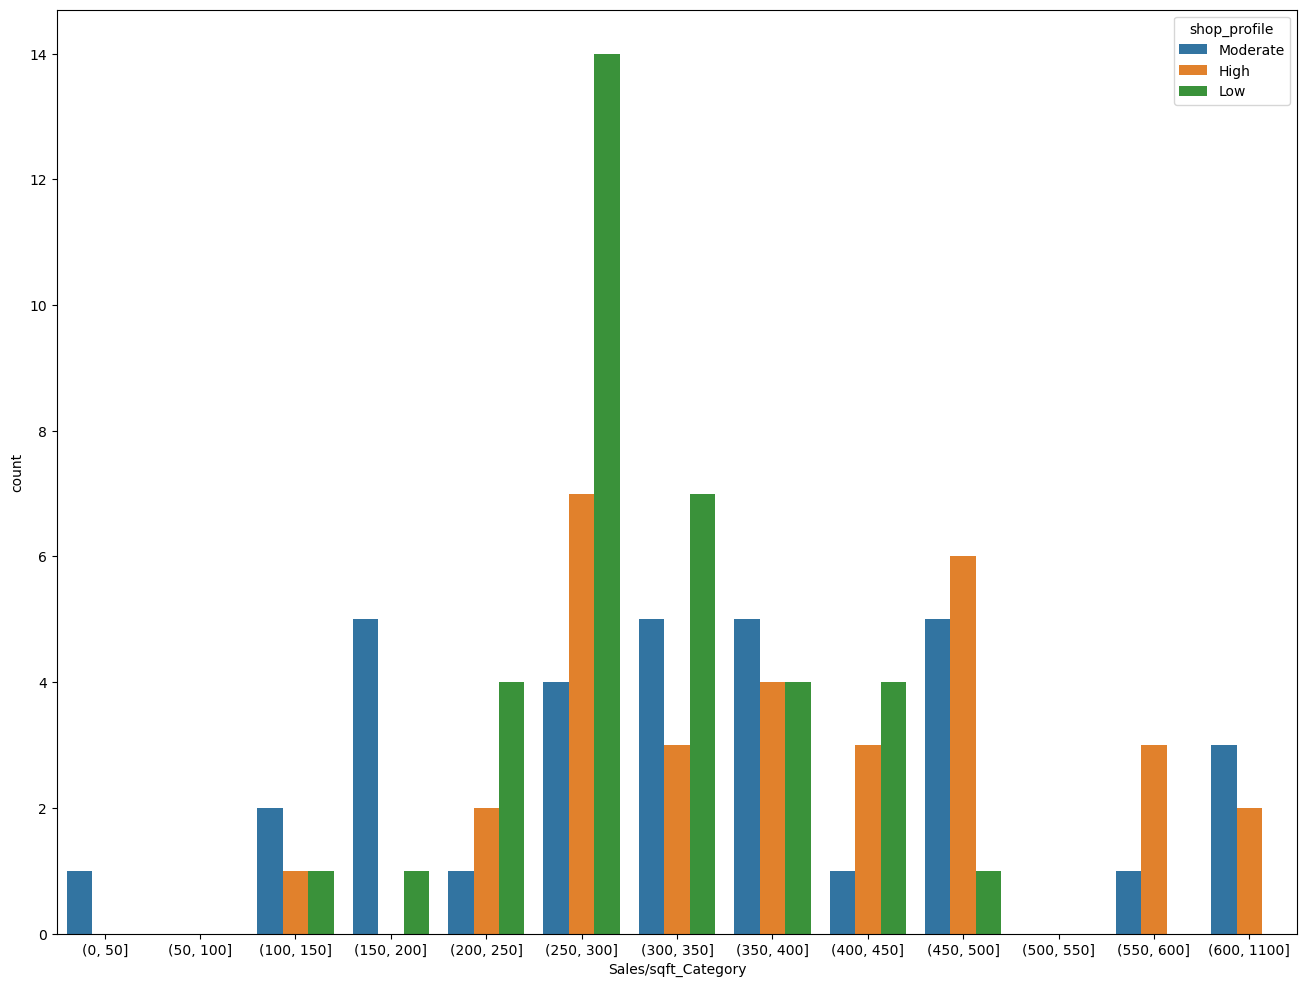

In [70]:
dataset['Sales/sqft_Category'] = pd.cut(dataset['sales/sqft'], bins=list(range(0,601,50))+[1100])

plt.figure(figsize=(16, 12))
sns.countplot(x = 'Sales/sqft_Category', data= dataset, hue='shop_profile')

In [47]:
dataset['sales/quant'] = dataset['total_sales']*1000/dataset['item_count']

In [48]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales,sales/sqft,sales/quant
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,619.991935,2870.564516,1992.758065,7360.000000,215.211448,362.163625,29.086528
std,126.770165,818.898817,562.809783,2168.576664,79.532387,158.446359,5.236446
min,298.000000,200.000000,187.000000,502.000000,13.124500,19.357670,20.992811
25%,553.250000,2368.250000,1607.250000,5857.250000,163.940500,267.158308,25.781074
50%,617.000000,2856.500000,2010.500000,7230.500000,206.281250,334.957848,28.214401
75%,676.000000,3389.000000,2397.500000,8694.750000,261.715000,436.695911,30.875435
max,1077.000000,4912.000000,3462.000000,13394.000000,605.120500,1097.691275,53.143464


<AxesSubplot:xlabel='Sales/quant_Category', ylabel='count'>

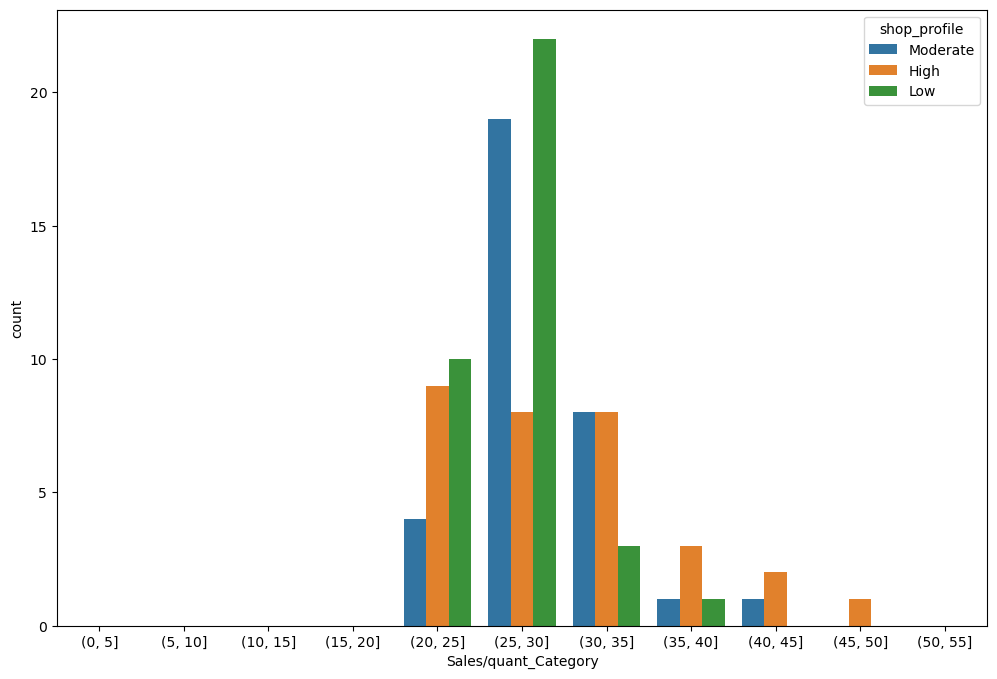

In [49]:
dataset['Sales/quant_Category'] = pd.cut(dataset['sales/quant'], bins=list(range(0,56,5)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'Sales/quant_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='shop_profile', ylabel='count'>

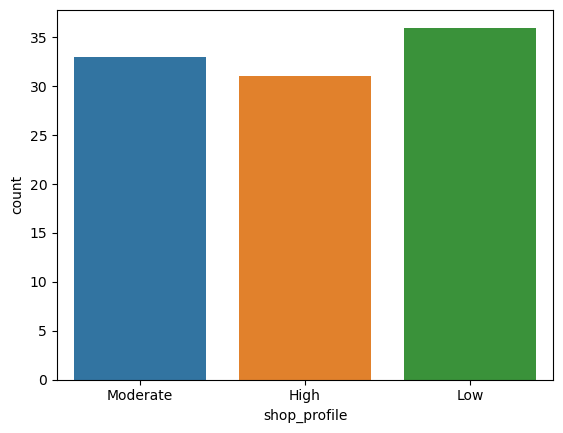

In [50]:
sns.countplot(x='shop_profile', data = dataset)

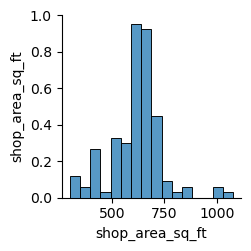

In [71]:
sns.pairplot(data=store_info_data)

**#RESTART**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold

store_info_data = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')
historical_data = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv')
testing_data = pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv')

print(store_info_data.head())
print(historical_data.head())
print(testing_data.head())

   shop_id  shop_area_sq_ft shop_profile
0  SHOP047              528     Moderate
1  SHOP009              676         High
2  SHOP083              676          Low
3  SHOP117              676          Low
4  SHOP042              676          Low
        item_description          transaction_date  invoice_id customer_id  \
0     ORANGE BARLEY 1.5L  2021-12-11T00:00:00.000Z       147.0        BGXA   
1       GINGER BEER 1.5L  2021-10-17T00:00:00.000Z       371.0        IA25   
2        TONIC PET 500ML  2021-12-13T00:00:00.000Z       484.0        VN7V   
3          CREAM SODA 1L  2021-12-13T00:00:00.000Z       484.0        VN7V   
4  STRAWBERRY MILK 180ML  2021-10-23T00:00:00.000Z      1310.0        7S00   

   shop_id  item_price  quantity_sold  
0  SHOP008         220              2  
1  SHOP112         220              2  
2  SHOP008         160              2  
3  SHOP008         150              2  
4  SHOP112         210              5  
   shop_id  shop_profile
0  SHOP046          

In [2]:
# Keeping duplicates and proceeding
# Assuming that duplicates are multiple items in the same bill
indexQuantity = historical_data[(historical_data['quantity_sold'] == 0)].index
historical_data.drop(indexQuantity,inplace = True)

In [3]:
# Compute total number of unique customers
unique_customers = historical_data.groupby(['shop_id'])['customer_id'].nunique()

unique_customers = unique_customers.rename('unique_customers')

store_info_data = store_info_data.merge(unique_customers, on='shop_id')

In [4]:
# Compute total number of unique transactions
transactions = historical_data.groupby(['shop_id'])['invoice_id'].nunique()

transactions = transactions.rename('transactions')

store_info_data = store_info_data.merge(transactions, on='shop_id')

In [5]:
# Compute total number of unique items
unique_items = historical_data.groupby('shop_id')['item_description'].nunique()

unique_items = unique_items.rename('unique_items')

store_info_data = store_info_data.merge(unique_items, on='shop_id')

In [6]:
# Compute total number of items
items = historical_data.groupby(['shop_id'])['quantity_sold'].sum()

items = items.rename('items')

store_info_data = store_info_data.merge(items, on='shop_id')

In [7]:
# Compute total revenue
historical_data['revenue'] = historical_data['item_price'] * historical_data['quantity_sold']

revenue = historical_data.groupby('shop_id')['revenue'].sum()

revenue = revenue.rename('revenue')

store_info_data = store_info_data.merge(revenue, on='shop_id')

In [8]:
# Compute max item_price
max_item_price = historical_data.groupby('shop_id')['item_price'].max()

max_item_price = max_item_price.rename('max_item_price')

store_info_data = store_info_data.merge(max_item_price, on='shop_id')

In [9]:
# Compute min item_price
min_item_price = historical_data.groupby('shop_id')['item_price'].max()

min_item_price = min_item_price.rename('min_item_price')

store_info_data = store_info_data.merge(min_item_price, on='shop_id')

In [10]:
# Compute max quantity_sold
max_quantity_sold = historical_data.groupby('shop_id')['quantity_sold'].max()

max_quantity_sold = max_quantity_sold.rename('max_quantity_sold')

store_info_data = store_info_data.merge(max_quantity_sold, on='shop_id')

In [11]:
# Compute min quantity_sold
min_quantity_sold = historical_data.groupby('shop_id')['quantity_sold'].max()

min_quantity_sold = min_quantity_sold.rename('min_quantity_sold')

store_info_data = store_info_data.merge(min_quantity_sold, on='shop_id')

In [12]:
# Compute avg price
# Average price of item (revenue/quantity)
price = revenue / items

price = price.rename('price')

store_info_data = store_info_data.merge(price, on='shop_id')

In [17]:
#Sales per sqft

store_info_data['spsf'] = store_info_data['revenue']/store_info_data['shop_area_sq_ft']



In [18]:
#Average transaction value

store_info_data['avg_transaction'] = store_info_data['revenue']/store_info_data['transactions']

In [19]:
store_info_data

,shop_id,shop_area_sq_ft,shop_profile,unique_customers,transactions,unique_items,items,revenue,max_item_price,min_item_price,max_quantity_sold,min_quantity_sold,price,spsf,avg_transaction
0,SHOP047,528,Moderate,920,1285,35,3288,842960,2200,2200,22,22,256.374696,1596.515152,656.000000
1,SHOP009,676,High,2476,3457,35,8411,1970870,2610,2610,28,28,234.320533,2915.488166,570.109922
2,SHOP083,676,Low,1876,2675,36,6644,1691985,3080,3080,24,24,254.663606,2502.936391,632.517757
3,SHOP117,676,Low,2015,3121,35,8073,2325980,1600,1600,25,25,288.118419,3440.798817,745.267542
4,SHOP042,676,Low,1826,2466,35,5844,1340215,2640,2640,25,25,229.331793,1982.566568,543.477291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1061,1472,35,3750,1128935,3360,3360,21,21,301.049333,2142.191651,766.939538
120,SHOP050,411,NaN,1765,3119,31,7668,2399125,2940,2940,41,41,312.874935,5837.287105,769.196858
121,SHOP061,699,NaN,1725,2314,35,6053,2110800,4500,4500,76,76,348.719643,3019.742489,912.186690
122,SHOP056,597,NaN,2810,4262,35,11163,3023805,2640,2640,45,45,270.877452,5065.000000,709.480291


**EVALUATION**

In [20]:
store_info_data["shop_profile"] = store_info_data["shop_profile"].replace({"High": 1, "Moderate": 2, "Low": 3})

In [21]:
non_empty_profiles = store_info_data[~store_info_data['shop_profile'].isna()]
empty_profiles = store_info_data[store_info_data['shop_profile'].isna()]

In [34]:
X = non_empty_profiles.drop(columns=["shop_id", "shop_profile"])
y = non_empty_profiles["shop_profile"]

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

scores_l = []
scores_knn = []
scores_svc = []
scores_rfc = []
scores_gnb = []

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=10)

# Get the scores from various models
from sklearn.metrics import f1_score

def get_score (model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return  f1_score(y_train, y_pred_train, average = 'micro'), f1_score(y_test,y_pred_test, average = 'micro')

from sklearn.preprocessing import StandardScaler,RobustScaler

for train_idx, test_idx in kf.split(X,y):
    
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    
    scores_l.append(get_score(LogisticRegression(max_iter = 3000), X_train, X_test, y_train, y_test))
    scores_knn.append(get_score(KNeighborsClassifier(n_neighbors=18), X_train, X_test, y_train, y_test))
    scores_svc.append(get_score(SVC(), X_train, X_test, y_train, y_test))
    scores_rfc.append(get_score(RandomForestClassifier(30), X_train, X_test, y_train, y_test))
    scores_gnb.append(get_score(GaussianNB(), X_train, X_test, y_train, y_test))

print("Logistic Regression scores are: ", scores_l, "\n")
print("K Nearest Neighbours scores are: ",scores_knn, "\n")
print("Support Vector Machines scores are: ",scores_svc, "\n")
print("Random Forest Classifier scores are: ",scores_rfc, "\n")
print("Gaussian N B scores are: ",scores_gnb, "\n")

Logistic Regression scores are:  [(0.64, 0.6), (0.72, 0.44), (0.6933333333333334, 0.56), (0.64, 0.4000000000000001)] 

K Nearest Neighbours scores are:  [(0.48, 0.48), (0.5333333333333333, 0.4000000000000001), (0.5333333333333333, 0.52), (0.4933333333333334, 0.68)] 

Support Vector Machines scores are:  [(0.5066666666666667, 0.48), (0.5333333333333333, 0.36), (0.48, 0.6), (0.5066666666666667, 0.48)] 

Random Forest Classifier scores are:  [(1.0, 0.56), (1.0, 0.64), (1.0, 0.52), (1.0, 0.72)] 

Gaussian N B scores are:  [(0.64, 0.52), (0.6, 0.44), (0.5466666666666666, 0.64), (0.6533333333333333, 0.64)] 



In [36]:
ss = StandardScaler()
X2 = ss.fit_transform(X)
X_test2 = ss.transform(X_test)
scores_l = []
for train_idx, test_idx in kf.split(X2,y):
    
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    
    scores_l.append(get_score(LogisticRegression(max_iter=5000), X_train, X_test, y_train, y_test))
    
print("Logistic Regression Scores are: ", scores_l)
print('\n')

Logistic Regression Scores are:  [(0.64, 0.6), (0.72, 0.44), (0.6933333333333334, 0.56), (0.64, 0.4000000000000001)]




In [40]:
#for n in range(2,16):
scores_rfc = []
for train_idx, test_idx in kf.split(X,y):

    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

    scores_rfc.append(get_score(RandomForestClassifier(70,max_depth=7,min_samples_split=6), X_train, X_test, y_train, y_test))
#print(n)
print("Random Forest Classifier scores are : ",scores_rfc)
#print(scores_rfc)

Random Forest Classifier scores are :  [(0.96, 0.56), (0.9866666666666668, 0.68), (0.9333333333333333, 0.6), (0.9733333333333334, 0.72)]


**Random Forest Classifier Submission Code**

In [49]:
rfc = RandomForestClassifier(70,max_depth=7,min_samples_split=6)
rfc.fit(X,y)

X_test = empty_profiles.drop(columns=["shop_id", "shop_profile"])

y_test = rfc.predict(X_test)

In [50]:
test_preds = pd.DataFrame({'shop_id':empty_profiles['shop_id'],'shop_profile':y_test})


In [51]:
len(test_preds)

24

In [52]:
test_preds

,shop_id,shop_profile
100,SHOP046,1.0
101,SHOP024,3.0
102,SHOP023,2.0
103,SHOP097,2.0
104,SHOP044,2.0
105,SHOP030,2.0
106,SHOP038,3.0
107,SHOP029,3.0
108,SHOP096,1.0
109,SHOP092,3.0


In [53]:
testing_data

,shop_id,shop_profile
0,SHOP046,NaN
1,SHOP024,NaN
2,SHOP023,NaN
3,SHOP097,NaN
4,SHOP044,NaN
5,SHOP030,NaN
6,SHOP038,NaN
7,SHOP029,NaN
8,SHOP096,NaN
9,SHOP092,NaN


In [54]:
test_preds["shop_profile"] = test_preds["shop_profile"].replace({1: 'High',2: "Moderate", 3:"Low"})

In [55]:
test_preds

,shop_id,shop_profile
100,SHOP046,High
101,SHOP024,Low
102,SHOP023,Moderate
103,SHOP097,Moderate
104,SHOP044,Moderate
105,SHOP030,Moderate
106,SHOP038,Low
107,SHOP029,Low
108,SHOP096,High
109,SHOP092,Low


In [56]:
filename = 'DataStorm087_Day1_1.csv'
test_preds.to_csv(filename,index=False)